In [1]:
from feature_selection_vif import select_features
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

from prettytable import PrettyTable

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

In [21]:
#sklearn models
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor

from prettytable import PrettyTable

### Load data

In [2]:
cleaned_df = pd.read_csv('./data/cleaned_rainfall_data.csv') 

In [3]:
cleaned_df.head()

,time,omega_x,omega_y,omega,pr_wtr,rhum_x,rhum_y,rhum,slp,tmp_y,tmp,uwnd_x,uwnd_y,uwnd,vwnd_x,vwnd_y,vwnd
0,1948-01-01,0.043999,-0.005003,-0.050001,9.959991,22.25,42.50,47.500015,101910.0,281.41998,296.07000,16.120010,4.600006,-1.879990,-1.209992,-0.589996,-1.989990
1,1948-01-02,0.094997,0.104998,0.006998,9.519989,19.50,32.75,51.250015,102190.0,282.12000,295.99000,18.000015,3.570007,-3.589996,-5.759995,-4.379990,-4.009995
2,1948-01-03,0.038998,0.036999,0.013998,10.220001,25.50,25.50,52.750015,102222.0,282.25000,295.91998,13.820007,3.570007,-2.759994,-3.939987,-1.909988,-1.259994
3,1948-01-04,0.264997,0.215998,0.077997,9.470001,11.25,15.75,50.500015,102042.0,282.20000,295.87000,14.750015,5.000015,-1.089996,-16.789993,-7.789993,-5.259995
4,1948-01-05,0.100998,0.128998,0.016998,11.269989,39.75,33.25,47.000015,102215.0,282.34998,295.80000,27.470001,9.320007,-3.309998,-12.139984,-6.079987,-3.259994


### Splitting the data into Train and Test Sets
Since it is a time series data, it will be splited on the time axis in order to avoid data leakage.

In [4]:
cleaned_df['time'] = pd.to_datetime(cleaned_df['time'])
cleaned_df.set_index('time', inplace=True)

In [5]:
# Seperating the features from the target
features_data = cleaned_df.drop('pr_wtr', axis=1)
target = cleaned_df['pr_wtr']

# Splitting the data into train and test, 80% for train and 20% for test.
X_train, X_test, y_train, y_test = train_test_split(features_data, target, test_size=0.2, shuffle=False)


#### Further Splitting the Train data into Training and Cross Validation Sets

In [6]:
# Splitting the train set into train and cross validation, 70% of 80% for Train and 30% of 80% for cross validation.
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=.3, shuffle=False)

print(len(X_train))
print(len(X_cv))
print(len(y_train))
print(len(y_cv))

14522
6224
14522
6224


### Feature selection using the "Variance Inflation Factor (VIF)" method.
Using the Variance Inflation Factor (VIF) method to check and remove Multicollinearity from the train set.  
The function `select_features` can be imported from `feature_selection_vif.py` file.

In [14]:
#perform feature selection using the above functions
#df = cleaned_df.drop(['pr_wtr'], axis=1) #time and pr_wtr are excluded from the exercise
threshold = 5
vif_df, features = select_features(X_train, threshold)

### Sanitary check => display the VIF dataframe and the selected features

In [15]:
display(vif_df)
print(features)

,Feature,Vif Factor
0,vwnd_y,4.129071
1,vwnd,3.892691
2,vwnd_x,3.404112
3,omega,3.239112
4,omega_x,3.220735
5,uwnd_x,2.568413
6,slp,2.409215
7,rhum_y,1.975518
8,tmp,1.673660
9,uwnd,1.660083


Index(['omega_x', 'omega', 'rhum_x', 'rhum_y', 'rhum', 'slp', 'tmp', 'uwnd_x',
       'uwnd', 'vwnd_x', 'vwnd_y', 'vwnd'],
      dtype='object')


### Making a train dataframe with the selected features

In [16]:
# make a dataframe of the selected features
X_train = X_train[features]
X_train.head()

,omega_x,omega,rhum_x,rhum_y,rhum,slp,tmp,uwnd_x,uwnd,vwnd_x,vwnd_y,vwnd
time,,,,,,,,,,,,
1948-01-01,0.043999,-0.050001,22.25,42.50,47.500015,101910.0,296.07000,16.120010,-1.879990,-1.209992,-0.589996,-1.989990
1948-01-02,0.094997,0.006998,19.50,32.75,51.250015,102190.0,295.99000,18.000015,-3.589996,-5.759995,-4.379990,-4.009995
1948-01-03,0.038998,0.013998,25.50,25.50,52.750015,102222.0,295.91998,13.820007,-2.759994,-3.939987,-1.909988,-1.259994
1948-01-04,0.264997,0.077997,11.25,15.75,50.500015,102042.0,295.87000,14.750015,-1.089996,-16.789993,-7.789993,-5.259995
1948-01-05,0.100998,0.016998,39.75,33.25,47.000015,102215.0,295.80000,27.470001,-3.309998,-12.139984,-6.079987,-3.259994


### Normalization and Standardization.
**Note:** Only the train set will be scaled or normalized to avoid data leakage.

In [18]:
# Normalizing and Standardizing the train data.
min_max_scaler = MinMaxScaler()
stand_scaler = StandardScaler()
min_max_norm_data = min_max_scaler.fit_transform(X_train)
stand_scaler_data = stand_scaler.fit_transform(X_train)

In [35]:
X_cv_scaled = stand_scaler.transform(X_cv[features])
X_test_scaled = stand_scaler.transform(X_test[features])

### Modeling

In [26]:
# Utility function
def evaluate_model(model, x, y):
    """
    Utility function to print the model performance, (MAE and MAPE)
    model: Fitted model
    x: cross validation features dataset
    y: cross validation target values
    """
    predicted = model.predict(x) #get predictions
    mae = mean_absolute_error(y_true=y, y_pred=predicted)
    mape = mean_absolute_percentage_error(y, predicted)
    
    print('MAE: {:.2f}'.format(mae))
    print('MAPE: {:.2f}%'.format(mape*100))
    print()

## Modeling with Different Regressors

In [36]:
# creating a dictionary of Regressors to be experimented on.
models_dict = {'Linear Reg': LinearRegression(), 'DT Regressor': DecisionTreeRegressor(random_state=0),
          'RF Regressor':RandomForestRegressor(random_state=0), 'Lasso': LassoCV(random_state=0), 'Ridge Regressor': RidgeCV(),
          'xgboost': XGBRegressor(),'Gradient Boost': GradientBoostingRegressor(random_state=0), 'SGDRegressor': SGDRegressor(random_state=0)
         }

#looping through all the regressors, fitting and evaluating them on Cross validation and test data respectively
for key, model in models_dict.items():
    model.fit(stand_scaler_data, y_train)
    print(f'Performance of "{key}" on Validation and Test set:')
    print('=='*28)
    print ( 'Validation set:')
    print("**"*8)
    evaluate_model(model,X_cv_scaled, y_cv)
    print ( 'Test set:')
    print("**"*8)
    evaluate_model(model,X_test_scaled, y_test)

Performance of "Linear Reg" on Validation and Test set:
Validation set:
****************
MAE: 2.84
MAPE: 23.02%

Test set:
****************
MAE: 2.83
MAPE: 26.36%

Performance of "DT Regressor" on Validation and Test set:
Validation set:
****************
MAE: 2.85
MAPE: 17.35%

Test set:
****************
MAE: 2.84
MAPE: 19.72%

Performance of "RF Regressor" on Validation and Test set:
Validation set:
****************
MAE: 1.94
MAPE: 11.75%

Test set:
****************
MAE: 2.00
MAPE: 14.56%

Performance of "Lasso" on Validation and Test set:
Validation set:
****************
MAE: 2.84
MAPE: 22.95%

Test set:
****************
MAE: 2.82
MAPE: 26.26%

Performance of "Ridge Regressor" on Validation and Test set:
Validation set:
****************
MAE: 2.84
MAPE: 23.02%

Test set:
****************
MAE: 2.83
MAPE: 26.36%

Performance of "xgboost" on Validation and Test set:
Validation set:
****************
MAE: 1.99
MAPE: 11.91%

Test set:
****************
MAE: 2.15
MAPE: 14.38%

Performance of 

### Retraining the best model

In [30]:
model = XGBRegressor()
model.fit(X_train, y_train)
# Evaluate the model by calling the "evaluate_model" function defined above
print('Cross validation scores:')
print('=='*12)
evaluate_model(model, X_cv[features], y_cv)

print('Test scores:')
print('=='*6)
evaluate_model(model, X_test[features], y_test)


Cross validation scores:
MAE: 1.99
MAPE: 11.91%

Test scores:
MAE: 2.15
MAPE: 14.38%



### Visualize the performance on Cross validation  and Test data

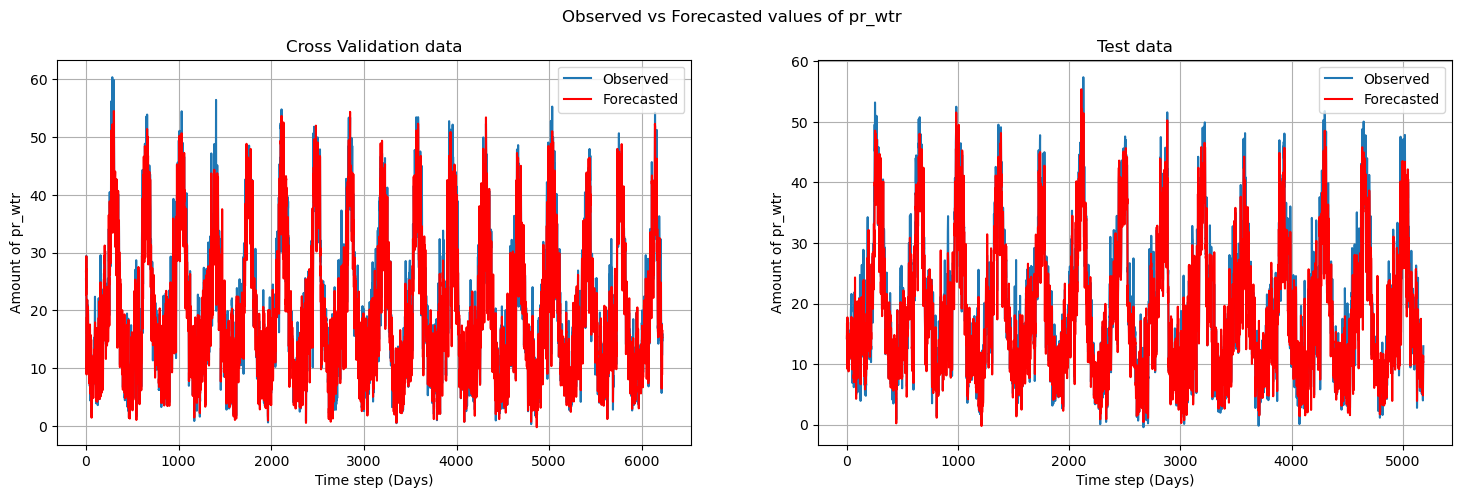

In [31]:
# Visualize the performance on Cross validation data
yhat_cv = model.predict(X_cv[features]) # predict on cross validation data
yhat_test = model.predict(X_test[features]) #predict on test data

# Plot the cross validation predictions and the true cv values
fig = plt.figure(figsize=(18,5))
fig.suptitle('Observed vs Forecasted values of pr_wtr')
ax1 = fig.add_subplot(121)
ax1.set_title('Cross Validation data')
ax1.plot(y_cv.values, label='Observed')
ax1.plot(yhat_cv, color='r', label='Forecasted')
plt.ylabel('Amount of pr_wtr')
plt.xlabel('Time step (Days)')
plt.legend()
plt.grid()

# Plot the test predictions and true values
ax2 = fig.add_subplot(122)
ax2.set_title('Test data')
ax2.plot(y_test.values, label='Observed')
ax2.plot(yhat_test, color='r', label='Forecasted')
plt.ylabel('Amount of pr_wtr')
plt.xlabel('Time step (Days)')
plt.legend()
plt.grid()
plt.show()

### Model Comparison

In [3]:
# Constructing the result summary table containing the scores for each model on cross validation and test dataset.

task1_result = PrettyTable()
task1_result.field_names = ["Regressor", "MAE on CV", "MAE on Test", "MAPE on CV (%)", "MAPE on Test (%)"]
task1_result.add_row(['Linear Reg', 2.84, 2.83, 23.02, 26.36])
task1_result.add_row(['DT Reg', 2.85, 2.84, 17.35, 19.72])
task1_result.add_row(['RF Reg', 1.94, 2.00, 11.75, 14.56])
task1_result.add_row(['Lasso Reg', 2.84, 2.82, 22.95, 26.26])
task1_result.add_row(['Ridge Reg', 2.84, 2.83, 23.03, 26.36])
task1_result.add_row(['XGBoost', 1.99, 2.15, 11.91, 14.38])
task1_result.add_row(['GradientBoost', 2.11, 2.14, 12.63, 14.68])
task1_result.add_row(['SGD Reg', 2.84, 2.84, 23.12, 26.53])
task1_result.add_row(['Prophet', 2.29, 2.29, 19.65, 19.65])

print('Result Summary for All Regressors:')
print(task1_result)

Result Summary for All Regressors:
+---------------+-----------+-------------+----------------+------------------+
|   Regressor   | MAE on CV | MAE on Test | MAPE on CV (%) | MAPE on Test (%) |
+---------------+-----------+-------------+----------------+------------------+
|   Linear Reg  |    2.84   |     2.83    |     23.02      |      26.36       |
|     DT Reg    |    2.85   |     2.84    |     17.35      |      19.72       |
|     RF Reg    |    1.94   |     2.0     |     11.75      |      14.56       |
|   Lasso Reg   |    2.84   |     2.82    |     22.95      |      26.26       |
|   Ridge Reg   |    2.84   |     2.83    |     23.03      |      26.36       |
|    XGBoost    |    1.99   |     2.15    |     11.91      |      14.38       |
| GradientBoost |    2.11   |     2.14    |     12.63      |      14.68       |
|    SGD Reg    |    2.84   |     2.84    |     23.12      |      26.53       |
|    Prophet    |    2.29   |     2.29    |     19.65      |      19.65       |
+----